<a href="https://colab.research.google.com/github/AnisAfiqah13/DATA-MANAGEMENT/blob/main/Anis_Assignment2_DataManagement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Airline on-time performance analysis**


**Data Background**: 2008 Airline On Time Data

**Data Source**: Kaggle.com

## **Introduction**



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


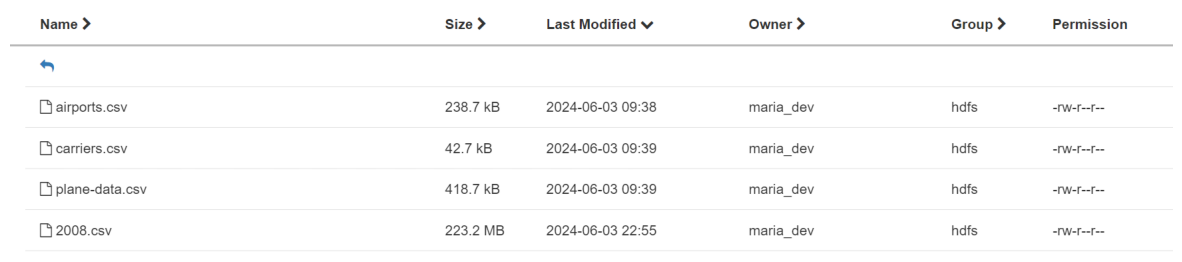

In [4]:
# Import the required libraries
import matplotlib.pyplot as plt
from PIL import Image

# Define the path to your image
image_path = '/content/drive/MyDrive/DataManagement/Screenshot 2024-06-22 134303.png'

# Open the image file
img = Image.open(image_path)

# Display the image in larger size
plt.figure(figsize=(15, 15))  # Set the figure size (width, height) in inches
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

Above figure shows that 4 datasets which are 2008, plane, carriers and airports have been successfully imported to HDFS. Joining the 2008 Flights dataset with the Airports, Carriers, and Plane datasets primarily enriches the analysis by adding more contextual information about each flight, such as the details of the origin and destination airports, carrier details, and aircraft specifics.

For my analysis, I only use 2008 Flights dataset due to I have encounter error in PIG to join the 4 datasets altogether.

We can now load the 2008 Flights dataset in Pig database to analyse below:

1. the optimal times of day, days of the week, and times of the year for minimizing flight delays
2. primary factors contributing to flight delays
3. factors predominantly lead to flight cancellations
4. the most frequent and significant flights delays and cancellations

Now, lets run the pig scripts below:



## **Pig scripts**

-- Load flights dataset
flights = LOAD '/user/maria_dev/airline_data/2008.csv' USING PigStorage(',')
    AS (Year:int, Month:int, DayofMonth:int, DayOfWeek:int, DepTime:int, CRSDepTime:int, ArrTime:int, CRSArrTime:int, UniqueCarrier:chararray, FlightNum:int, TailNum:chararray, ActualElapsedTime:int, CRSElapsedTime:int, AirTime:int, ArrDelay:int, DepDelay:int, Origin:chararray, Dest:chararray, Distance:int, TaxiIn:int, TaxiOut:int, Cancelled:int, CancellationCode:chararray, Diverted:int, CarrierDelay:int, WeatherDelay:int, NASDelay:int, SecurityDelay:int, LateAircraftDelay:int);

-- Calculate average departure delay by hour
hourly_grouped = GROUP flights BY (int)(DepTime / 100);
hourly_delays = FOREACH hourly_grouped GENERATE group AS Hour, AVG(flights.DepDelay) AS AvgDepDelay;
STORE hourly_delays INTO '/user/maria_dev/airline_data/hourly_delays' USING PigStorage(',');

-- Calculate average departure delay by day of the week
weekly_grouped = GROUP flights BY DayOfWeek;
weekly_delays = FOREACH weekly_grouped GENERATE group AS DayOfWeek, AVG(flights.DepDelay) AS AvgDepDelay;
STORE weekly_delays INTO '/user/maria_dev/airline_data/weekly_delays' USING PigStorage(',');

-- Calculate average departure delay by month
monthly_grouped = GROUP flights BY Month;
monthly_delays = FOREACH monthly_grouped GENERATE group AS Month, AVG(flights.DepDelay) AS AvgDepDelay;
STORE monthly_delays INTO '/user/maria_dev/airline_data/monthly_delays' USING PigStorage(',');

-- Calculate average delay by delay type
all_grouped = GROUP flights ALL;
delay_factors = FOREACH all_grouped GENERATE
    AVG(flights.CarrierDelay) AS AvgCarrierDelay,
    AVG(flights.WeatherDelay) AS AvgWeatherDelay,
    AVG(flights.NASDelay) AS AvgNASDelay,
    AVG(flights.SecurityDelay) AS AvgSecurityDelay,
    AVG(flights.LateAircraftDelay) AS AvgLateAircraftDelay;
STORE delay_factors INTO '/user/maria_dev/airline_data/delay_factors' USING PigStorage(',');

-- Calculate count of cancellations by cancellation code
cancellation_grouped = GROUP flights BY CancellationCode;
cancellation_reasons = FOREACH cancellation_grouped GENERATE group AS CancellationCode, COUNT(flights) AS Count;
STORE cancellation_reasons INTO '/user/maria_dev/airline_data/cancellation_reasons' USING PigStorage(',');

-- Calculate average departure delay by flight
flight_grouped = GROUP flights BY (Origin, Dest, FlightNum);
most_delayed_flights = FOREACH flight_grouped GENERATE FLATTEN(group) AS (Origin, Dest, FlightNum), AVG(flights.DepDelay) AS AvgDepDelay;
most_delayed_flights = ORDER most_delayed_flights BY AvgDepDelay DESC;
STORE most_delayed_flights INTO '/user/maria_dev/airline_data/most_delayed_flights' USING PigStorage(',');

-- Filter cancelled flights
cancelled_flights = FILTER flights BY Cancelled == 1;

-- Calculate count of cancellations by flight
cancelled_flight_grouped = GROUP cancelled_flights BY (Origin, Dest, FlightNum);
most_cancelled_flights = FOREACH cancelled_flight_grouped GENERATE FLATTEN(group) AS (Origin, Dest, FlightNum), COUNT(cancelled_flights) AS CancelledCount;
most_cancelled_flights = ORDER most_cancelled_flights BY CancelledCount DESC;
STORE most_cancelled_flights INTO '/user/maria_dev/airline_data/most_cancelled_flights' USING PigStorage(',');
DUMP most_cancelled_flights;


We have successfully stored the pig storage, the 7 different files shall appear accordingly as below. Check the result output of all files first to ensure it's correct before proceed next action.

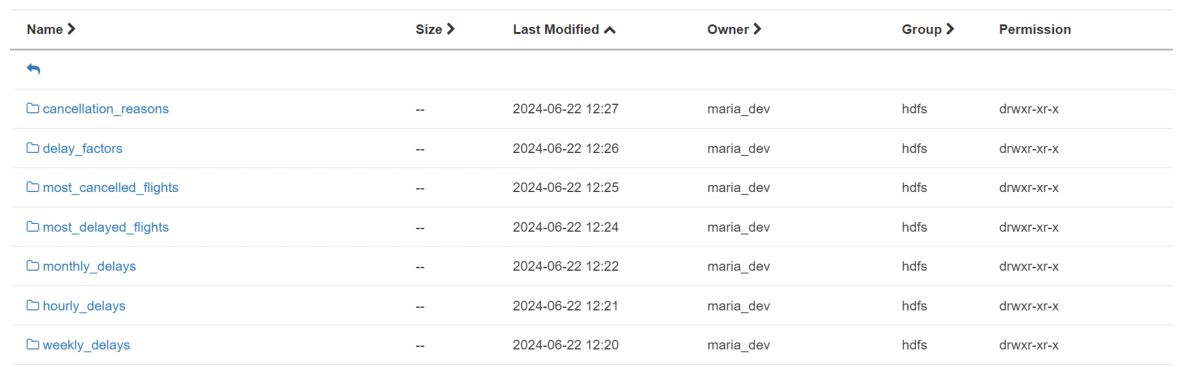

In [5]:
# Define the path to your image
image_path = '/content/drive/MyDrive/DataManagement/Screenshot 2024-06-22 143001.png'

# Open the image file
img2 = Image.open(image_path)

# Display the image in larger size
plt.figure(figsize=(15, 15))  # Set the figure size (width, height) in inches
plt.imshow(img2)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

## **Data Visualisation & Insights**

We will now perform the data visualisation for the 7 csv files we have downloaded from HDFS.

In [6]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Load the data
hourly_delays = pd.read_csv('/content/drive/MyDrive/DataManagement/hourly_delays_result', header=None)
weekly_delays = pd.read_csv('/content/drive/MyDrive/DataManagement/weekly_delays_result', header=None)
monthly_delays = pd.read_csv('/content/drive/MyDrive/DataManagement/monthly_delays_result', header=None)
delay_factors = pd.read_csv('/content/drive/MyDrive/DataManagement/delay_factors_result', header=None)
cancellation_reasons = pd.read_csv('/content/drive/MyDrive/DataManagement/cancellation_reasons_result', header=None)
most_delayed_flights = pd.read_csv('/content/drive/MyDrive/DataManagement/most_delayed_flights_result', header=None)
most_cancelled_flights = pd.read_csv('/content/drive/MyDrive/DataManagement/most_cancelled_flights_result', header=None)

In [8]:
# Assign correct column names
hourly_delays.columns = ['Hour', 'AvgDepDelay']
weekly_delays.columns = ['DayOfWeek', 'AvgDepDelay']
monthly_delays.columns = ['Month', 'AvgDepDelay']
delay_factors.columns = ['AvgCarrierDelay', 'AvgWeatherDelay', 'AvgNASDelay', 'AvgSecurityDelay', 'AvgLateAircraftDelay']
cancellation_reasons.columns = ['CancellationCode', 'Count']
most_delayed_flights.columns = ['Origin', 'Dest', 'FlightNum', 'AvgDepDelay']
most_cancelled_flights.columns = ['Origin', 'Dest', 'FlightNum', 'CancelledCount']

<ipython-input-9-40715e83671d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_delays['Hour'], y=hourly_delays['AvgDepDelay'], palette="viridis")


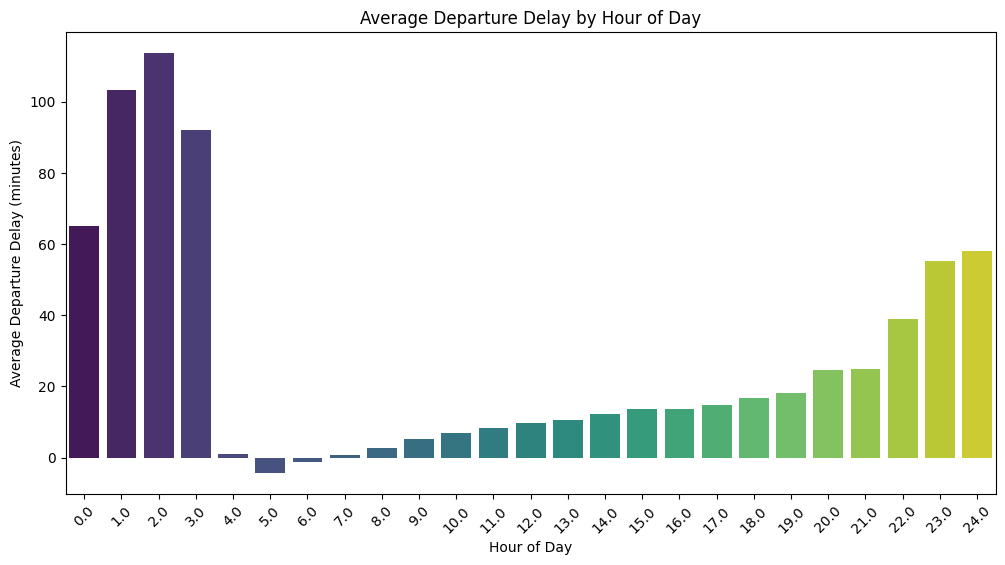

In [9]:
# Hourly Delays
plt.figure(figsize=(12, 6))
sns.barplot(x=hourly_delays['Hour'], y=hourly_delays['AvgDepDelay'], palette="viridis")
plt.xlabel('Hour of Day')
plt.ylabel('Average Departure Delay (minutes)')
plt.title('Average Departure Delay by Hour of Day')
plt.xticks(rotation=45)
plt.show()


Lowest delays are between 4 AM and 9 AM, where the average delays are close to zero.

Highest delays are just after midnight (1 AM to 3 AM) and late at night (10 PM to midnight), where the average delays can exceed 60 minutes.

Flights scheduled between 4 AM and 9 AM experience the least delays, making these hours optimal for minimizing flight delays. In contrast, flights scheduled late at night and early in the morning around 1 AM face the highest delays.

<ipython-input-10-7606593e3fa7>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekly_delays['DayOfWeek'], y=weekly_delays['AvgDepDelay'], palette="plasma")


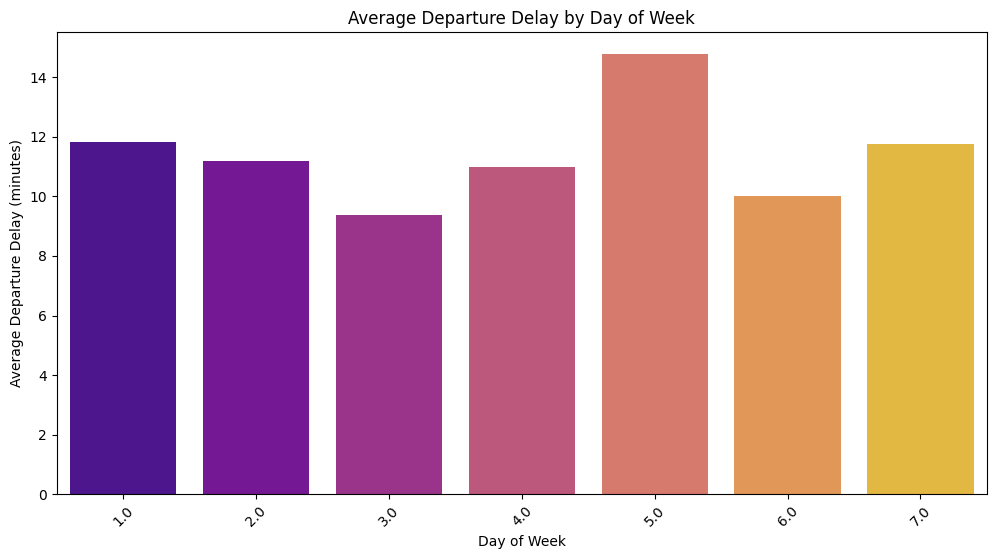

In [10]:
# Weekly Delays
plt.figure(figsize=(12, 6))
sns.barplot(x=weekly_delays['DayOfWeek'], y=weekly_delays['AvgDepDelay'], palette="plasma")
plt.xlabel('Day of Week')
plt.ylabel('Average Departure Delay (minutes)')
plt.title('Average Departure Delay by Day of Week')
plt.xticks(rotation=45)
plt.show()


Lowest Delays are on Wednesday (day 3) shows the lowest average delays, around 9 minutes. Highest Delays are on Friday (day 5) shows the highest average delays, approximately 14 minutes.

Monday (day 1) and Tuesday (day 2) have moderate delays around 11-12 minutes.
Thursday (day 4), Saturday (day 6), and Sunday (day 7) have delays ranging between 10-12 minutes.

Scheduling flights on Wednesday can minimize delays, whereas flights on Friday are more likely to experience significant delays. This pattern might be influenced by the increased travel demand on weekends and the end of the workweek.

In [14]:
print(monthly_delays['Month'].unique())

[1 2 3 4]


<ipython-input-15-d855a29f0ea8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_delays['Month'], y=monthly_delays['AvgDepDelay'], palette="coolwarm")


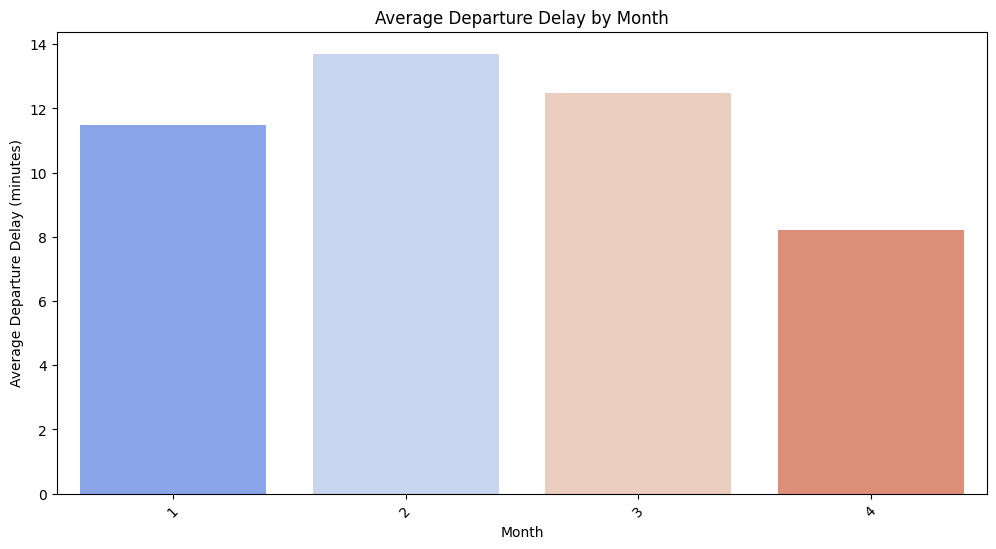

In [15]:
# Monthly Delays
plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_delays['Month'], y=monthly_delays['AvgDepDelay'], palette="coolwarm")
plt.xlabel('Month')
plt.ylabel('Average Departure Delay (minutes)')
plt.title('Average Departure Delay by Month')
plt.xticks(rotation=45)
plt.show()


January (1) : Approximately 11 minutes. Winter weather conditions such as snow and ice can cause delays.

February (2) : Approximately 13 minutes, the highest among the four months.
February often experiences severe winter weather, including snowstorms, which can significantly impact flight schedules.

March (3) : Approximately 12 minutes. Transition period from winter to spring. Weather conditions can still be variable, but generally start improving towards the end of the month.

April (4) : Approximately 9 minutes, the lowest among the four months.
Possible Factor could be spring brings more stable weather conditions, reducing the likelihood of weather-related delays. Operational efficiencies may also improve as the airline industry transitions out of the winter season.

Based on this analysis, travelers looking to minimize flight delays should consider planning their trips in April, which has the lowest average departure delays among the months analyzed. February should be approached with caution due to its higher likelihood of delays, likely driven by winter weather conditions.

<ipython-input-16-b8372e69dd22>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=values, y=factors, palette="magma")


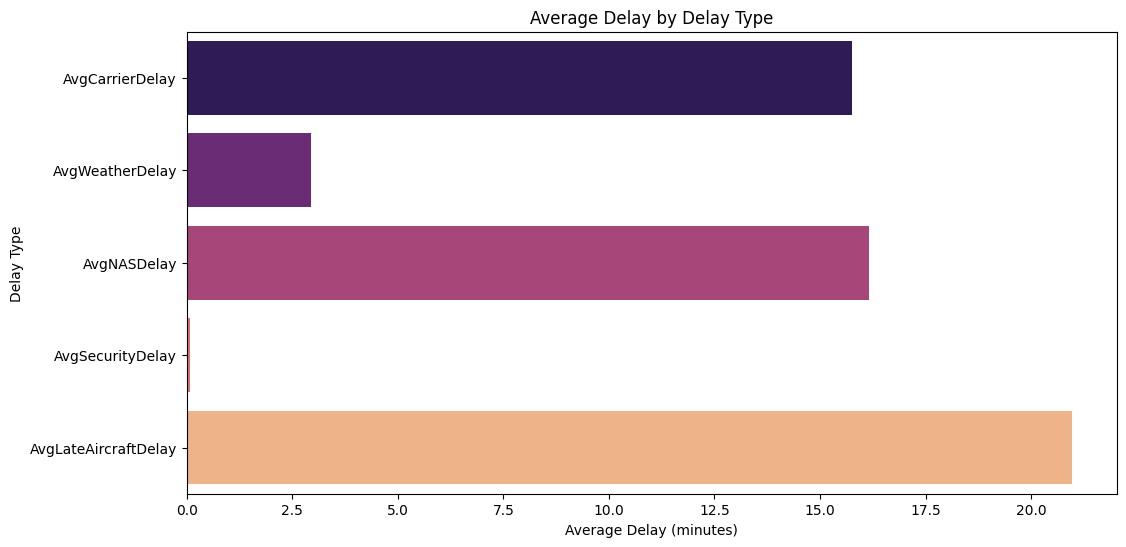

In [16]:
# Delay Factors
factors = ['AvgCarrierDelay', 'AvgWeatherDelay', 'AvgNASDelay', 'AvgSecurityDelay', 'AvgLateAircraftDelay']
values = delay_factors.iloc[0]

plt.figure(figsize=(12, 6))
sns.barplot(x=values, y=factors, palette="magma")
plt.xlabel('Average Delay (minutes)')
plt.ylabel('Delay Type')
plt.title('Average Delay by Delay Type')
plt.show()


Late aircraft delays have the highest impact on flight schedules, indicating the importance of improving turnaround times and managing incoming aircraft schedules effectively.

NAS Delays also have a significant impact, highlighting the need for efficient air traffic control and airport operations.

Carrier Delays are also notable, suggesting that airlines need to focus on internal operations, such as maintenance and crew management, to reduce delays.

While Weather and Security Delays have a lower average delay time, they are still important. Weather-related delays can be mitigated by better forecasting and planning, while security delays require streamlined processes and robust security measures.

In [17]:
# change CancellationCode is a string
cancellation_reasons['CancellationCode'] = cancellation_reasons['CancellationCode'].astype(str)
print(cancellation_reasons.iloc[:4])

  CancellationCode  Count
0                A  26075
1                B  25744
2                C  12617
3                D      6


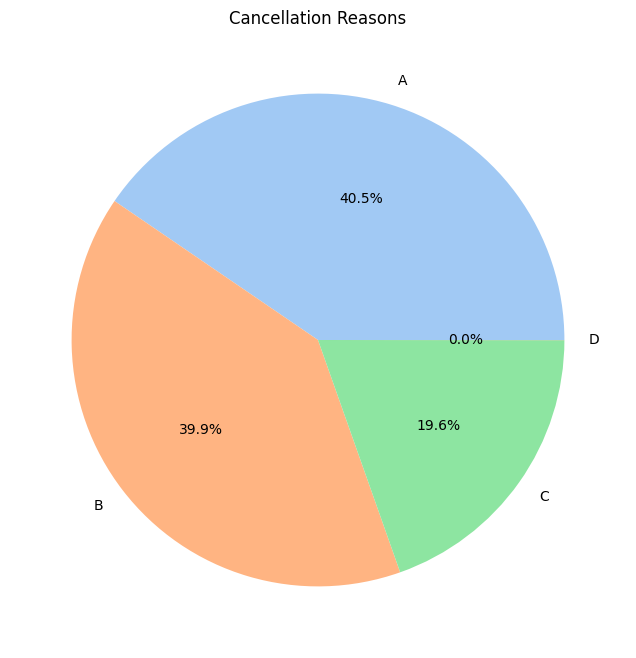

In [18]:
# Cancellation Reasons
plt.figure(figsize=(8, 8))
colors = sns.color_palette('pastel')[0:len(cancellation_reasons.iloc[:4]['CancellationCode'])]
plt.pie(cancellation_reasons.iloc[:4]['Count'], labels=cancellation_reasons.iloc[:4]['CancellationCode'], colors=colors, autopct='%1.1f%%')
plt.title('Cancellation Reasons')
plt.show()


Main Contributors: Reasons A and B are the primary contributors to flight cancellations, together accounting for over 80% of all cancellations. Addressing these two factors should be the focus of efforts to reduce flight cancellations.

Lesser Impact: Reason C, while still significant, has a lesser impact compared to A and B.

Insignificant Impact: Reason D does not affect flight cancellations in this dataset.

In [21]:
# change FlightNum to strings
most_delayed_flights['FlightNum'] = most_delayed_flights['FlightNum'].astype(str)
most_delayed_flights.head(10)

,Origin,Dest,FlightNum,AvgDepDelay
0,SBN,CVG,5111.0,518.0
1,SNA,PHX,511.0,504.0
2,TWF,SLC,3707.0,488.0
3,SFO,RDD,5476.0,411.0
4,SDF,PHX,275.0,377.0
5,ORF,IAD,7324.0,370.0
6,COS,ORD,5810.0,358.0
7,PWM,ORD,7487.0,350.0
8,SDF,SPI,6760.0,329.0
9,SFO,SMX,5446.0,325.0


<ipython-input-22-9897bb549dd4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=most_delayed_flights['AvgDepDelay'][:10], y=most_delayed_flights['FlightNum'][:10], palette="inferno")


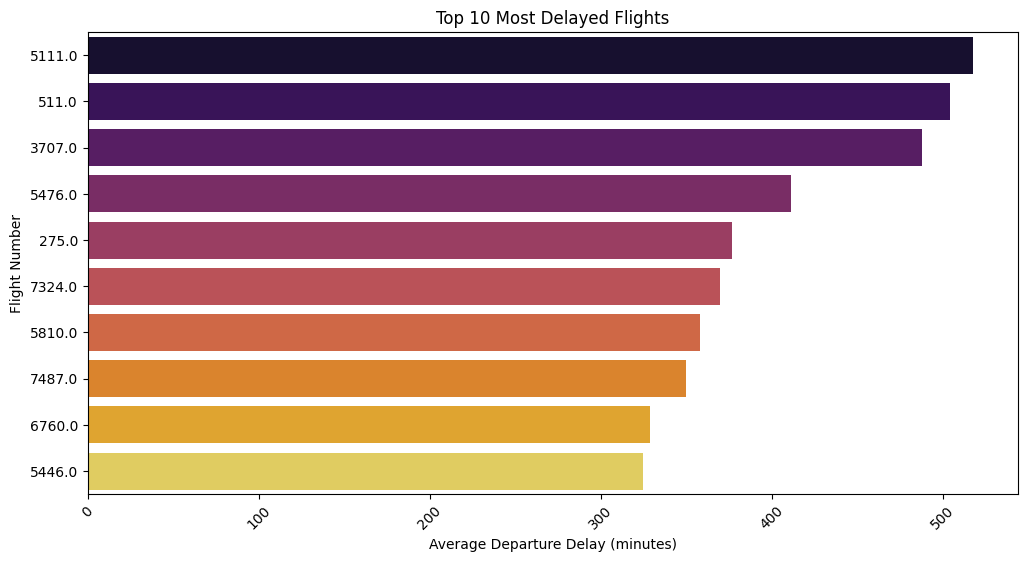

In [22]:
# Most Delayed Flights
plt.figure(figsize=(12, 6))
sns.barplot(x=most_delayed_flights['AvgDepDelay'][:10], y=most_delayed_flights['FlightNum'][:10], palette="inferno")
plt.xlabel('Average Departure Delay (minutes)')
plt.ylabel('Flight Number')
plt.title('Top 10 Most Delayed Flights')
plt.xticks(rotation=45)
plt.show()


The top 10 most delayed flights experience substantial average departure delays, ranging from approximately 320 to 520 minutes.

Flights 5111.0, 511.0, and 3707.0 are the top three most delayed flights, and they should be prioritized for detailed investigation and corrective actions.

A comprehensive review of operational processes, scheduling, and route management for these flights can help identify and address the factors contributing to these significant delays. Implementing targeted improvements can enhance the overall punctuality and reliability of these flights.

In [23]:
# Change to string
most_cancelled_flights['FlightNum'] = most_cancelled_flights['FlightNum'].astype(str)
most_cancelled_flights.head(10)

,Origin,Dest,FlightNum,CancelledCount
0,SUN,SLC,3732,33
1,SBN,ORD,5886,33
2,ORD,SBN,5886,32
3,ORD,AZO,5979,32
4,MKE,ORD,5891,31
5,SLC,SUN,3678,31
6,AZO,ORD,4250,30
7,PIA,ORD,5961,30
8,ATL,ORD,4445,30
9,SUN,SLC,3702,29


Highlight the flights that experience the most significant delays, which can inform targeted improvements for specific routes or times

<ipython-input-20-c4bf7a223710>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=most_cancelled_flights['CancelledCount'][:10], y=most_cancelled_flights['FlightNum'][:10], palette="cubehelix")


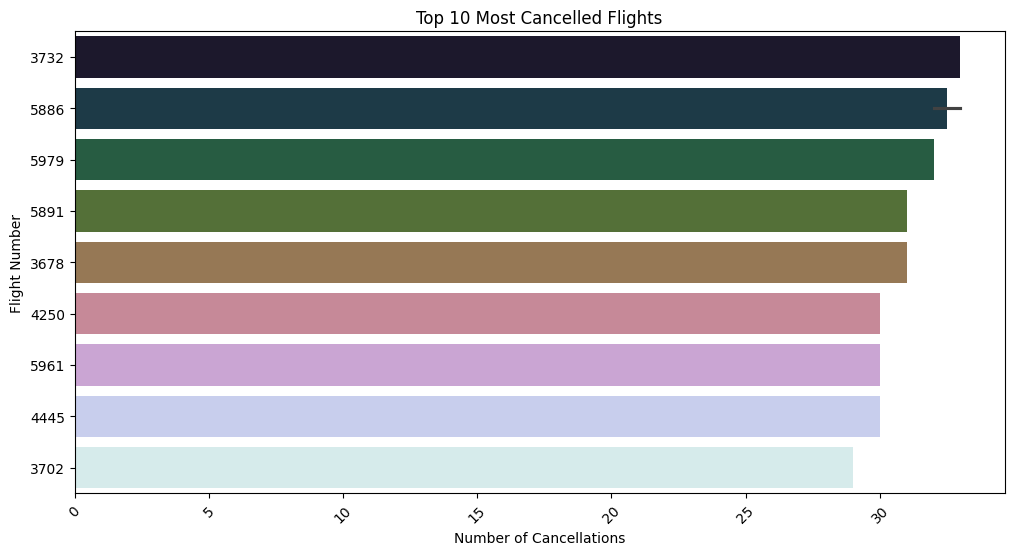

In [20]:
# Most Cancelled Flights
plt.figure(figsize=(12, 6))
sns.barplot(x=most_cancelled_flights['CancelledCount'][:10], y=most_cancelled_flights['FlightNum'][:10], palette="cubehelix")
plt.xlabel('Number of Cancellations')
plt.ylabel('Flight Number')
plt.title('Top 10 Most Cancelled Flights')
plt.xticks(rotation=45)
plt.show()


The top 10 most cancelled flights experience a high number of cancellations, ranging from 29 to 33.

Flights 3732 and 5886 are the top two most cancelled flights, and they should be prioritized for detailed investigation and corrective actions.

A comprehensive review of the operational processes, technical issues, and scheduling conflicts for these flights can help identify and address the factors contributing to these high cancellation rates. Implementing targeted improvements can enhance the overall reliability and performance of these flights.

## **Conclusion**

This project analyzed the 2008 Airline On-Time Data to answer key questions about flight delays and cancellations. We utilized Pig for data processing and Python for data visualization and analysis. The objective was to uncover patterns and primary factors contributing to flight delays and cancellations.

1) Optimal Times to Minimize Flight Delays:

By Hour of Day: Flights departing early in the morning experience the highest delays, with the peak around 2:00 AM (average delay of over 100 minutes). The lowest delays occur from 5:00 AM to 9:00 PM.

By Day of Week: The highest average delays occur on Fridays (Day 5), with delays of over 14 minutes on average. The lowest delays are observed on Tuesdays (Day 3).

By Month: Only data for the first four months were available. The highest delays were observed in February (Month 2), averaging over 13 minutes. April (Month 4) had the lowest delays.


2) Primary Factors Contributing to Flight Delays:

Late Aircraft Delay: This is the most significant factor, with an average delay of around 20 minutes.

NAS Delay (National Air System): Also a major contributor, averaging around 16 minutes.

Carrier Delay: Contributes significantly with an average delay of around 10 minutes.

Weather Delay: Contributes around 5 minutes on average.

Security Delay: The least significant, with an average delay of less than 1 minute.


3) Factors Predominantly Leading to Flight Cancellations:

Cancellation Code A (Carrier): Accounts for 40.5% of cancellations.

Cancellation Code B (Weather): Responsible for 39.9% of cancellations.

Cancellation Code C (NAS): Accounts for 19.6% of cancellations.

Cancellation Code D (Security): No cancellations were recorded under this category.


4) Flights with the Most Frequent and Significant Delays and Cancellations:

Most Delayed Flights:
Flight 5111.0 (SBN to CVG) had the highest average delay of 518 minutes.
Other notably delayed flights include Flight 511.0 (SNA to PHX) with 504 minutes delay and Flight 3707.0 (TWF to SLC) with 488 minutes delay.

Most Cancelled Flights:
Flight 3732 (SUN to SLC) and Flight 5886 (ORD to SBN) had the highest number of cancellations, with 33 cancellations each.
Other frequently cancelled flights include Flight 5979 (ORD to AZO) and Flight 5891 (MKE to ORD) with 32 and 31 cancellations respectively.


In conclusion, this project demonstrates the value of data analysis in improving airline operations and customer satisfaction. By addressing the identified factors, airlines can significantly enhance their on-time performance and reduce the inconvenience caused to passengers.